In [21]:
# importing the required libraries
import torch
import torchvision
# setting up the various hyperparameters involved
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [22]:
# importing the training data from the MNIST dataset of pytorch. normalizing it with the global mean and standard deviation values of the dataset. they are grayscale images
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/results/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
# importing the testing data. performing similar operations
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/results/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [23]:
# setting up a tensor which can output a few images of the test dataset for visualisation
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

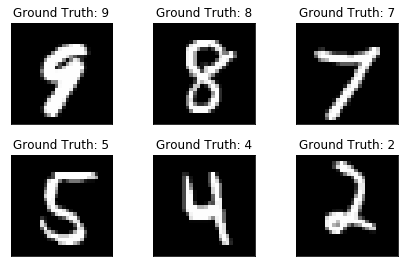

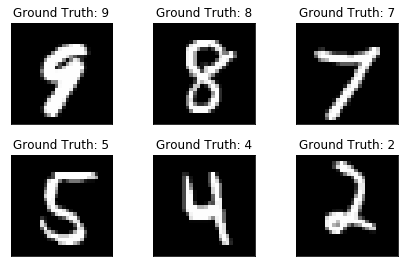

In [24]:
# importing the library to output the images so that we get a better understanding of the dataset which we are going to handle
import matplotlib.pyplot as plt

fig = plt.figure()
# for loop to output 6 images
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [25]:
# importing the libraries required to create a convolutional neural network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [26]:
# defining the class containing our CNN
class Net(nn.Module):
#    defining the function containing the various layers(i.e 2 convolutional, 2 fully connected and a dropout layer)
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
# defining the function containing the connections between the various layers in a sequence. we will be using the relu function
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [27]:
# creating our neural network
network = Net()
# applying the various parameters which were defined earlier to our neural network
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [28]:
# creating counters to hold the training losses, no. of images trained, testing losses and no. of images tested
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [29]:
# creating a class to train the neural network
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
#    making all the gradients zero before the start of a new epoch
    optimizer.zero_grad()
#    performing output, forward connections, backpropagation and updating the weights and biases after every step.
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
#     printing the progress of our neural network after every batch has been trained
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#       saving the progress of our network after every epoch
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [30]:
# creating a function to test our neural network
def test():
  network.eval()
# keeping a counter for the number of images tested and the number of images correctly guessed
  test_loss = 0
  correct = 0
# counting the number of images guessed correctly and the loss functions value for each time the images have been tested
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
test()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3043, Accuracy: 1047/10000 (10%)



In [31]:
# finally training our neural network and also testing it after every epoch
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314842
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.325303
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.251332
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.259714
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.202215
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.163879
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.122574
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.954031
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974031
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.841717
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.669056
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.582327
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.539359
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.564009
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.307033
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.291520
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.085601
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.254403
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.033557
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.251143
Train Epoch: 1 [12800/60000 (